# Fraudulent Transaction Monitoring

This notebook provides an end-to-end approach to fraud detection in credit card transactions.

This data comes from Kaggle, and you can access the link here:
https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

All of my visualizations are in the <i>Visualizations</i> folder of my github page.

Thank you for visiting!

Jimmy

# Analytical Steps

Below are the steps I take to conduct this analysis.

* <b>Step 1:</b> Packages and Dataset Import
* <b>Step 2:</b> Target, Predictors, and Train-Test Split
* <b>Step 3:</b> Exploratory Data Analysis
* <b>Step 4:</b> Baseline Model Development
* <b>Step 5:</b> Assessing Baseline Model Performance Through Cross Validation
* <b>Step 6:</b> Understanding Feature Importance Using Gini Gain
* <b>Step 7:</b> Conclusion and Next Steps

# Step 1. Packages and Dataset Import

In [ ]:
####Import required python packages
from collections import Counter
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sb

import numpy as np
import pandas as pd

import sklearn as sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split,KFold,TimeSeriesSplit,cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score,recall_score,f1_score,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn import tree

# import shap

# Oversampling and under sampling
# from imblearn.over_sampling import RandomOverSampler, SMOTE
# from imblearn.under_sampling import RandomUnderSampler, NearMiss

import scipy.stats as stats

In [ ]:
%%sql @noteable
/*Using SQL to query the dataset*/
SELECT*
FROM 'Scratch Data Sets, Articles and Ideas/Credit Card Fraud.csv'

In [ ]:
##read in the data set using pandas
fraud_df=pd.read_csv(r"Scratch Data Sets, Articles and Ideas/Credit Card Fraud.csv")

In [ ]:
fraud_df.set_index('Time',inplace=True)
fraud_df.sort_index(inplace=True)

y=fraud_df['Class']
X=fraud_df.drop(labels='Class',axis=1)

# Step 2. Target, Predictors, and Train-Test Split

The <b>Time</b> column contains the time at which the transaction was completed. This is the column on which we will divide our train and test samples, because this mirrors how we will detect fraud in reality.

The <b>Class</b> column contains the fraud indicator. We notice this is imbalanced so we may have to adjust our sample to achieve reasonable model performance scores.

We will set <b>Time</b> as the index of the dataframe and <b>Class</b> as the Y variable.

First we'll create a train and test split on the sample.

In [ ]:
tss=TimeSeriesSplit(n_splits=2)

train_split_indices,test_split_indices=tss.split(X)
X_train,X_test=X.iloc[train_split_indices[1],:],X.iloc[test_split_indices[1],:]
y_train,y_test=y.iloc[train_split_indices[1]],y.iloc[test_split_indices[1]]

We can see this time series split in a plot below.

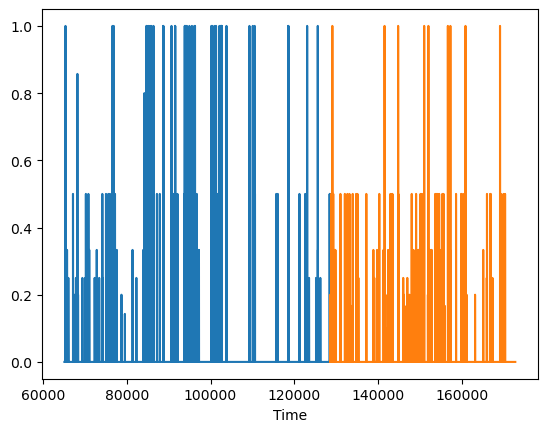

In [ ]:
y_fig=plt.figure()

_=y_train.groupby('Time').mean().plot()
_=y_test.groupby('Time').mean().plot()
plt.savefig('Visualizations/Time Series Split.png')

Now we'll create the cross-validation splits on the sample. We could use this for hyperparameter tuning after we make a model selection.

In [ ]:
##TIME SERIES CROSS VALIDATION
cross_val_tss=TimeSeriesSplit(n_splits=5)

##these are the 5 folds we created based on the time
for i, (train_index, test_index) in enumerate(cross_val_tss.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")


Fold 0:
  Train: index=[    0     1     2 ... 47469 47470 47471]
  Test:  index=[47472 47473 47474 ... 94936 94937 94938]
Fold 1:
  Train: index=[    0     1     2 ... 94936 94937 94938]
  Test:  index=[ 94939  94940  94941 ... 142403 142404 142405]
Fold 2:
  Train: index=[     0      1      2 ... 142403 142404 142405]
  Test:  index=[142406 142407 142408 ... 189870 189871 189872]
Fold 3:
  Train: index=[     0      1      2 ... 189870 189871 189872]
  Test:  index=[189873 189874 189875 ... 237337 237338 237339]
Fold 4:
  Train: index=[     0      1      2 ... 237337 237338 237339]
  Test:  index=[237340 237341 237342 ... 284804 284805 284806]


# Step 3. Exploratory Data Analysis
I will now begin conducting the exploratory data analysis phase. I will begin understanding the basis of the data, missing values, anomalies and what each column represents.

In [ ]:
fraud_df.describe()

In [ ]:
##Checking for missing values
fraud_df.isnull().values.any()

False

There are no missing values.

In [ ]:
fraud_df.shape

(284807, 30)

In [ ]:
fraud_df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

<b>Observations</b>:
It appears that there are no discrete variables and no missing values. Because we do not have the variable names (they were removed), we cannot make any judgements about these columns. Additionally, we want to retain each outlier, because it could be an indicator of fraudulent activity.

## Correlations Between Features
We'll now understand the correlations between features, as well as between each feature and the target variable.

In [ ]:
fraud_df.corr()

Now we can observe correlations through a heatmap.

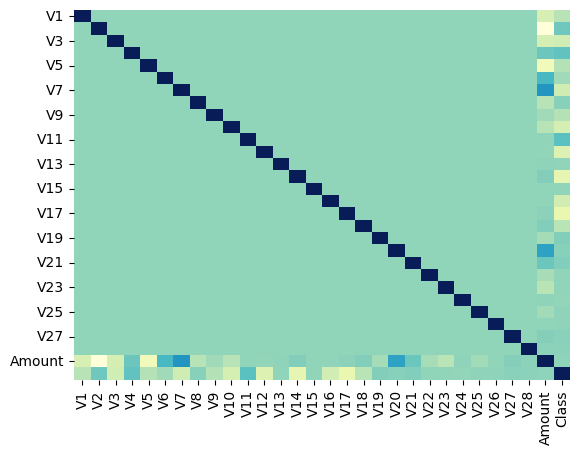

In [ ]:
correlation_plot=plt.figure()
_= sb.heatmap(fraud_df.corr(),cmap="YlGnBu",cbar=False)
plt.savefig('Visualizations/Feature Correlations.png')

We note that there is not much correlation between the "V..." features. However, several of the features correlate with <b>Amount</b> and <b>Class</b> (which is our target).

Before we move to selecting the features that have high correlations with the target, we are going to standardize every feature. Because we will likely have outliers, we need to use a scaling approach that can be robust to outliers. We will use the <b>RobustScaler</b> approach.

In [ ]:
robust_scaler_train=RobustScaler()
robust_scaler_test=RobustScaler()

X_train_standardized=robust_scaler_train.fit_transform(X_train)
X_train_standardized = pd.DataFrame(X_train_standardized, columns=X_train.columns)

X_test_standardized=robust_scaler_test.fit_transform(X_test)
X_test_standardized = pd.DataFrame(X_test_standardized, columns=X_test.columns)


Now we will assess correlation of these features with the target variable, using the point-biserial correlation coefficient, which assesses correlation between a categorical variable and continuous variables. We will set a threshold of <b>.2 as the minimum correlation for a feature to be considered in our model</b>. We may adjust this value later.

In [ ]:

point_bi_serial_list=X_train_standardized
point_bi_serial_threshold = .2
pointbiserialr=stats.pointbiserialr
corr_data=pd.DataFrame()
for i in point_bi_serial_list:
    pbc=pointbiserialr(y_train,X_train_standardized[i])
    corr_temp_data=[[i,pbc.correlation,"point_bi_serial"]]
    corr_temp_df=pd.DataFrame(corr_temp_data,columns=['Feature','Correlation','Correlation_Type'])
    corr_data=corr_data.append(corr_temp_df)

# Filter NA and sort based on absolute correlation
corr_data = corr_data.iloc[corr_data.Correlation.abs().argsort()]
corr_data = corr_data[corr_data['Correlation'].notna()]
corr_data = corr_data.loc[corr_data['Correlation'] != 1]

# Add thresholds

# initialize list of lists
data = [['point_bi_serial', point_bi_serial_threshold]]
threshold_df=pd.DataFrame(data,columns=["Correlation_Type","Threshold"])
corr_data=pd.merge(corr_data,threshold_df,on=["Correlation_Type"],how="left")
corr_data2 = corr_data.loc[corr_data['Correlation'].abs() > corr_data['Threshold']]
corr_top_features = corr_data2['Feature'].tolist()

corr_top_features

['V3', 'V16', 'V10', 'V7', 'V12', 'V14', 'V17']

Now, we'll use the feature scaling to create some boxplots that demonstrate the relationship between each feature and our target. First we have to convert <b>y_train</b> to a categorical variable.

In [ ]:
# corr_train=X_train_standardized
# fraud_df.columns
standardized_cols=[col for col in fraud_df.columns if "V" in col or "Amount" in col]
fraud_df_subset=fraud_df[standardized_cols]
rs=RobustScaler()
fraud_df_subset_scaled=rs.fit_transform(fraud_df_subset)
fraud_df_standardized=fraud_df
fraud_df_standardized[standardized_cols]=fraud_df_subset_scaled

In [ ]:
class_nf = fraud_df_standardized[fraud_df_standardized['Class'] == 0]
class_f = fraud_df_standardized[fraud_df_standardized['Class'] == 1]

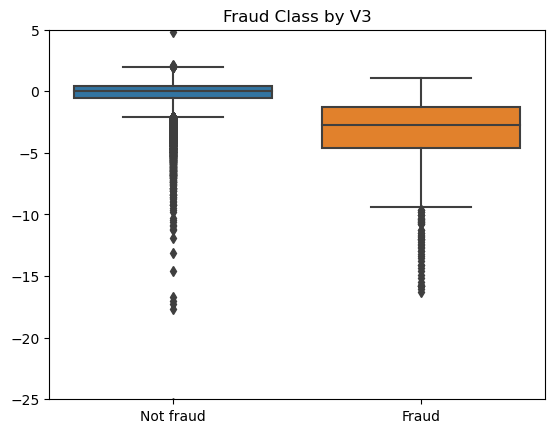

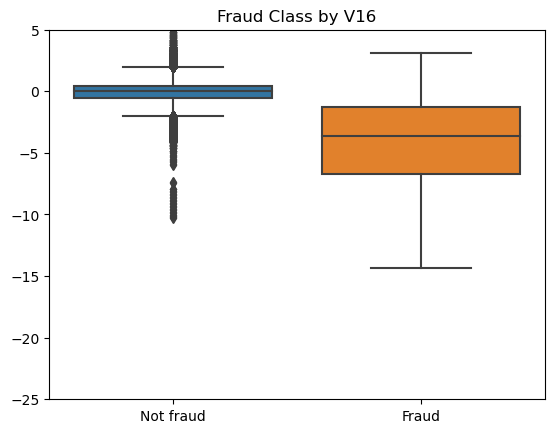

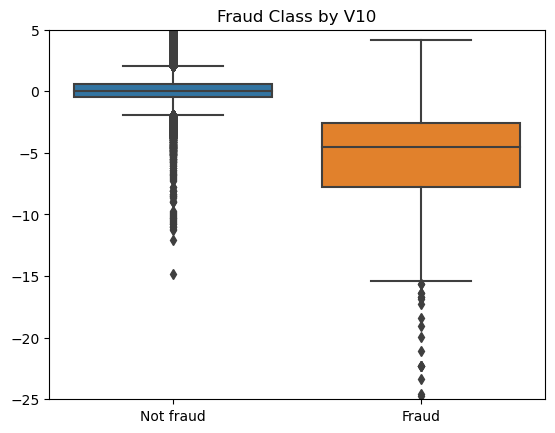

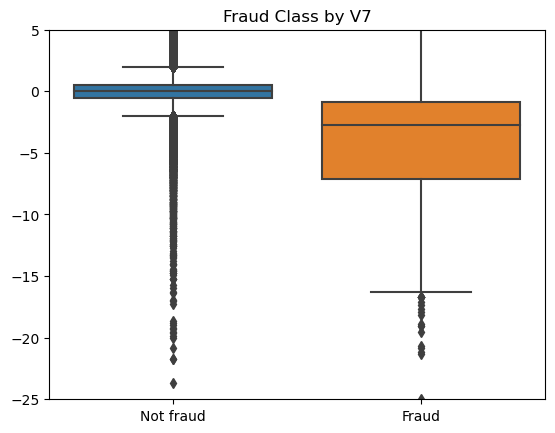

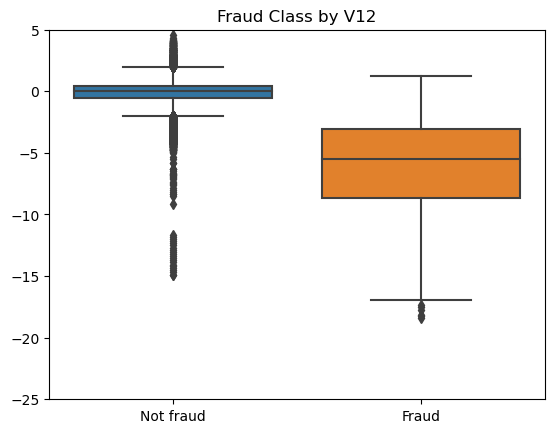

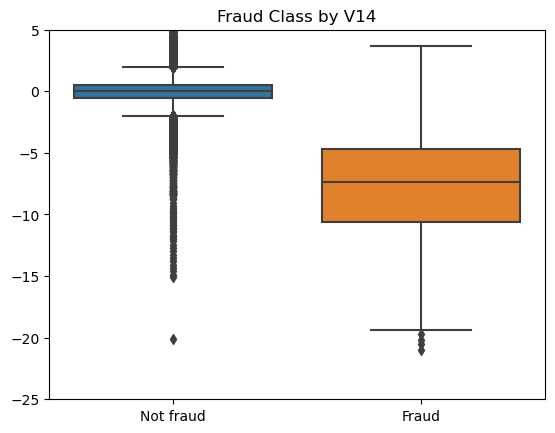

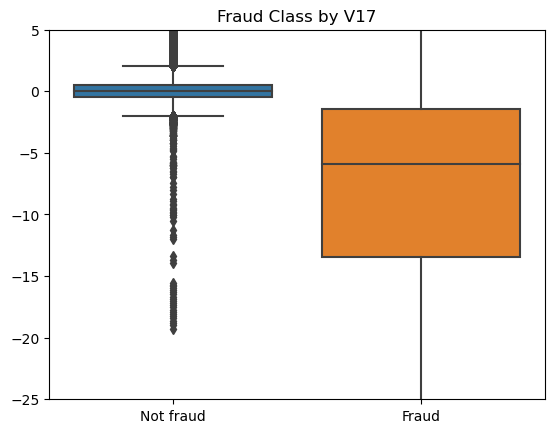

In [ ]:
for feature in corr_top_features:
    feature_plot=plt.figure()
    _=sb.boxplot(data=[class_nf[feature], class_f[feature]])
    plt.title("Fraud Class by "+feature)
    plt.xticks([0,1], ["Not fraud", "Fraud"])
    plt.ylim(-25,5)
    plt.savefig(f"Visualizations/{feature} Relationship with Target.png")

It is clear from these box plots that there is an inverse relationship between each of these highly predictive features and the target <b>Class</b>.

Fraudulent transactions seem to have lower values of <b>['V3', 'V16', 'V10', 'V7', 'V12', 'V14', 'V17']</b>. We cannot interpret what this means in context, as we don't have any description of the features. However, if I did have knowledge of what the features are, I would look conduct a sanity check to ensure that the inverse relationhip makes sense.

# <b>Step 4:</b> Baseline Model Development

Now we will build a baseline model to use to iterate on. We will start with a <b>decision tree</b>, and then we will move to a basic <b>logistic regression</b>.

## Model Type: Decision Tree

In [ ]:
model_scores={}
####MODEL TYPE: DECISION TREE
##Now time to train a decision tree model
##Not going to do any cross validation yet until I work on tuning the hyperparameters using grid search
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_standardized[corr_top_features], y_train)

y_pred = decision_tree.predict(X_test_standardized[corr_top_features])
model_df = pd.DataFrame({'Real Values':y_test, 'Decision Tree Predicted Values':y_pred})

# The score method returns the accuracy of the model
score = decision_tree.score(X_test_standardized[corr_top_features], y_test)
model_scores['Decision Tree']={'Accuracy':score}
print(score)

0.9990835835045031


## Model Type: Logistic Regression

In [ ]:
####MODEL TYPE: Logistic Regression
logistic=LogisticRegression()
logistic.fit(X_train_standardized[corr_top_features], y_train)

y_pred = logistic.predict(X_test_standardized[corr_top_features])
model_df['Logistic Predicted Values']=y_pred
score=logistic.score(X_test_standardized[corr_top_features],y_test)
model_scores['Logistic Regression']={'Accuracy':score}
print(score)

0.9994417232843524


In [ ]:
##Write Function
def CV_report(n_folds,model):
    tscv = TimeSeriesSplit(n_splits=n_folds)
    scores_accuracy=cross_val_score(model,X,y,cv=tscv)
    scores_precision=cross_val_score(model,X,y,cv=tscv,scoring='precision')
    scores_recall=cross_val_score(model,X,y,cv=tscv,scoring='recall')
    scores_f1=cross_val_score(model,X,y,cv=tscv,scoring='f1')
    performance_metrics={'Accuracy':
                         {'Mean':scores_accuracy.mean(),
                          'Standard Deviation':scores_accuracy.std()},
                        'Precision':
                         {'Mean':scores_precision.mean(),
                          'Standard Deviation':scores_precision.std()},
                        'Recall':
                         {'Mean':scores_recall.mean(),
                          'Standard Deviation':scores_recall.std()},
                        'F1':
                         {'Mean':scores_f1.mean(),
                         'Standard Deviation':scores_f1.std()}  
                                  }
    return performance_metrics

# Step 5: Assessing Baseline Model Performance Through Cross Validation
Now we will conduct time series cross validation for each of the models. I'm creating a model called <b>CV_report</b> to report the cross-validation metrics. 

#### Definitions of Performance Metrics

<b>Accuracy</b>: Accuracy is calculated as the number of true positives (accurately identified fraud) plus true negatives (accurately identified non-fraud) divided by the total number of predictions.

<b>Precision</b>: Precision is calculated as the number of true positives divided by the number of true positives plus false positives (incorrectly identified fraud).

<b>Recall</b>: Recall is calculated as the number of true positives divided by the number of true positives plus false negatives (fraudulent transactions that were missed).

<b>F1</b>: F1 is a measure of a model’s accuracy and precision. It is calculated as the harmonic mean of precision and recall.


In [ ]:
##Decision Tree Cross Validation Report
cv_decision_tree=DecisionTreeClassifier()
d_tree_report=CV_report(5,cv_decision_tree)
print(d_tree_report)

{'Accuracy': {'Mean': 0.9987359639328375, 'Standard Deviation': 0.0007417353876770573}, 'Precision': {'Mean': 0.6271523453715235, 'Standard Deviation': 0.1309338360556379}, 'Recall': {'Mean': 0.6492198760145158, 'Standard Deviation': 0.05736630135464339}, 'F1': {'Mean': 0.5285839279787548, 'Standard Deviation': 0.2122927193230453}}


In [ ]:
##Logistic Regression Cross Validation Report
cv_logistic=LogisticRegression()
logistic_report=CV_report(5,cv_logistic)
print(logistic_report)

{'Accuracy': {'Mean': 0.998542145069206, 'Standard Deviation': 0.0008228002072011262}, 'Precision': {'Mean': 0.606192539790351, 'Standard Deviation': 0.17519050429385277}, 'Recall': {'Mean': 0.41607775449480056, 'Standard Deviation': 0.22235715576648635}, 'F1': {'Mean': 0.4465499021663593, 'Standard Deviation': 0.1557706325164541}}


Below you will find code that produces a chart demonstrating the performance metrics for each of the basic model types.

<Figure size 640x480 with 0 Axes>

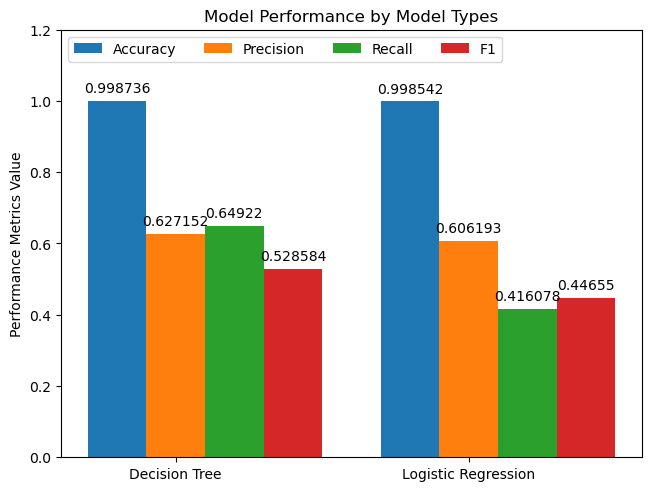

In [ ]:

###setting up performance charts
accuracy_numbers=[d_tree_report['Accuracy']['Mean'],logistic_report['Accuracy']['Mean']]
precision_numbers=[d_tree_report['Precision']['Mean'],logistic_report['Precision']['Mean']]
recall_numbers=[d_tree_report['Recall']['Mean'],logistic_report['Recall']['Mean']]
F1_numbers=[d_tree_report['F1']['Mean'],logistic_report['F1']['Mean']]

model_types = ('Decision Tree','Logistic Regression')
performance_metrics = {
    'Accuracy': accuracy_numbers,
    'Precision': precision_numbers,
    'Recall': recall_numbers,
    'F1': F1_numbers
}


x = np.arange(len(model_types))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

plt.figure(1)
fig, ax = plt.subplots(layout='constrained')

for attribute, value in performance_metrics.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, value, width, label=attribute)
    ax.bar_label(rects, padding=4)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance Metrics Value')
ax.set_title('Model Performance by Model Types')
ax.set_xticks(x + width, model_types)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 1.2)

plt.savefig('Visualizations/Model Performance by Model Types.png')

#### Conclusion
We want to ensure we capture more of the fraudulent transactions even if that means we identify non-fraud as fraud. Therefore we should prioritize Recall. <b>The best performing model in terms of Recall is the Decision Tree.</b> We also see that the F1 of the decision tree is superior.

# Step 6: Understanding Feature Importance Using Gini Gain
Since we decided that the <b>Decision Tree</b> is the best performing, let's understand the structure of the tree.

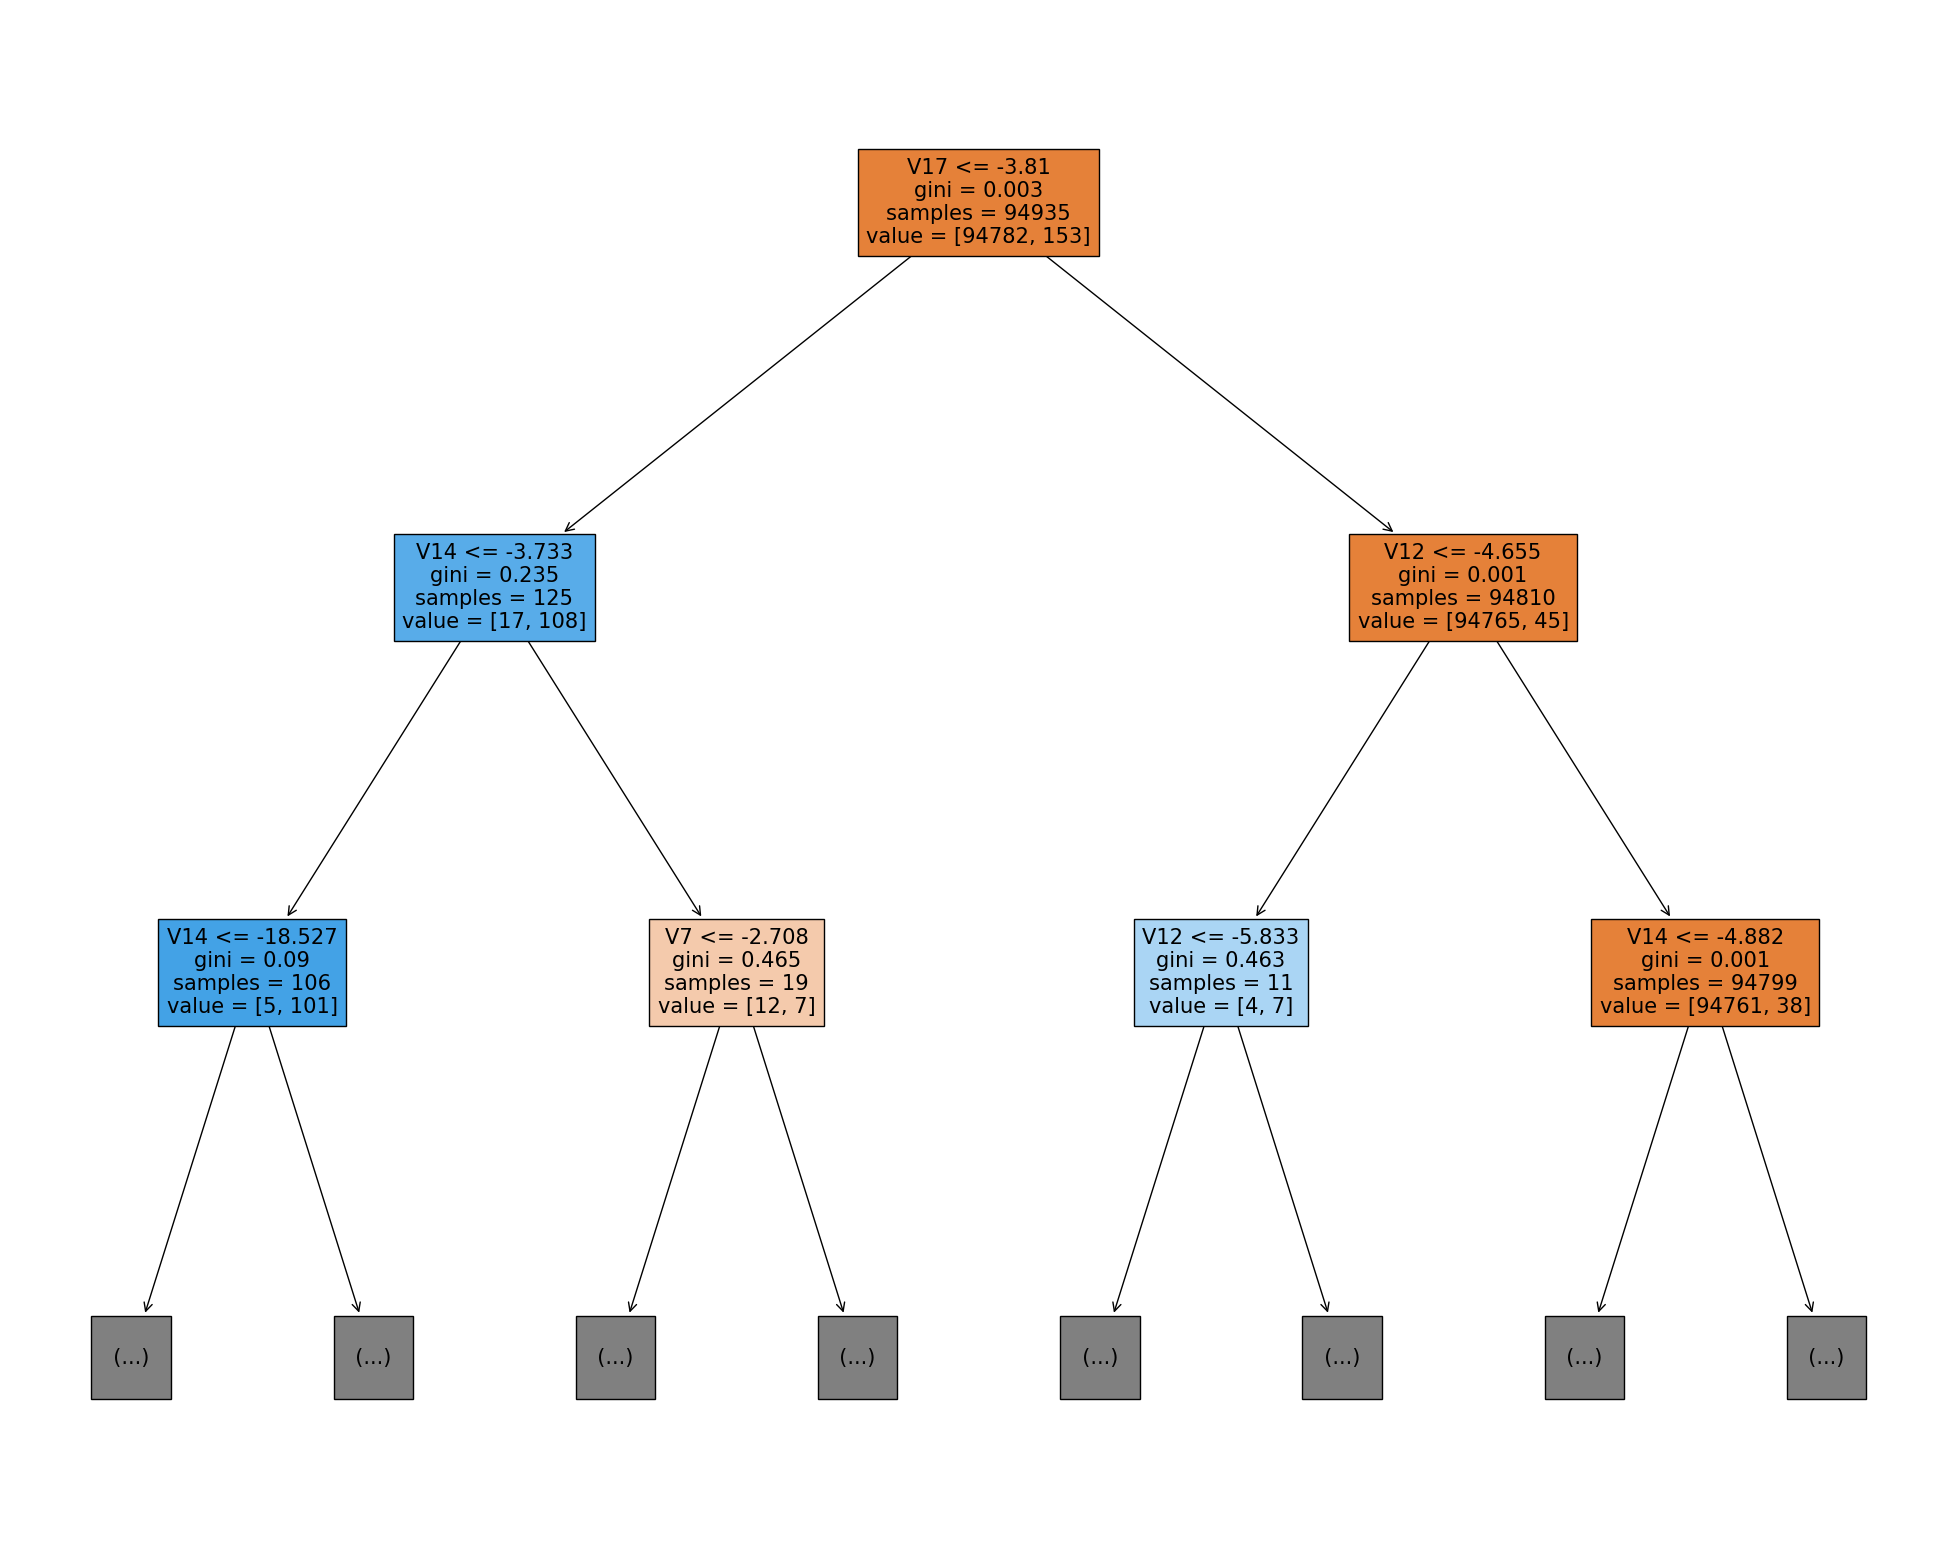

In [ ]:
fig1=plt.figure(figsize=(25,20))
_=tree.plot_tree(decision_tree, max_depth=2,feature_names=corr_top_features,filled=True)
fig1.savefig("Visualizations/initial_decision_tree.png")

Decision trees are formed through the process of <b>gini gain</b>. Every node split is determined by finding the split that gains the most "knowledge" in the model. The visualization above illustrates each of the splits for the first few layers.

In the visualization above, We see that splitting the training dataset on <b>V17</b> at the value of -3.81 initially. gains the most information initially. We then observe splits occuring on V14 and V12.

While these features and values lack meaning, due to anonymity of the dataset, we see the value of visualizing a decision tree for model interpretability. Now, we'll explore feature importance via Shapley values.

# Step 7: Conclusion and Next Steps

Thus far, I've created a few models on the data set, evaluated performance of the models, selected a preliminary model (the decision tree), and finally, illustrated the model in a visualization.

Now I would like to discuss my next steps:
- Explore additional baseline models such as Support Vector Machines
- Analyze the errors the models make when making predictions
- Conduct hyperparameter tuning on the selected model using K-fold cross-validation and possibly grid search
- Explore more sophisticated ensemble methods like Gradient Boosting Machine and Random Forest
- Consider using multiple model types to optimize for both precision and recall
- Test the final model on a completed new test sample to check for overfitting or underfitting

Thank you for reading through my analysis. I would welcome any feedback via email jpwhite1206@gmail.com as I build out this analysis further.

In [ ]:
%%bash
